In [3]:
%pip install numpy tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ========================
# CONFIG
# ========================
SEQ_LENGTH = 60
FEATURE_COLUMNS = ['open', 'high', 'low', 'close', 'volume']
TARGET_COLUMNS = ['close', 'high', 'low']
EPOCHS = 10
BATCH_SIZE = 32
TRAIN_FILE = "datasets/BTC-USD_1h_Training_data.csv"
TEST_FILE = "datasets/BTC-USD_1h_Testing_data.csv"
DATETIME_COLUMN = 'timestamp'  # Adjust this if your datetime column is named differently

# ========================
# HELPERS
# ========================
def load_data(filepath: str, features: list[str], include_time=False) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    if include_time:
        df[DATETIME_COLUMN] = pd.to_datetime(df[DATETIME_COLUMN])
        return df[[DATETIME_COLUMN] + features]
    return df[features]

def normalize_data(df: pd.DataFrame, scaler: MinMaxScaler = None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df.values)
    else:
        scaled = scaler.transform(df.values)
    return scaled, scaler

def create_sequences(data: np.ndarray, target_indices: list[int], seq_length: int):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i][target_indices])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape: tuple[int, int], output_dim: int) -> Sequential:
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_predictions(actual: np.ndarray, predicted: np.ndarray, columns: list[str], time_labels=None):
    plt.figure(figsize=(15, 6))
    for i, col in enumerate(columns):
        plt.subplot(1, len(columns), i + 1)
        x = time_labels if time_labels is not None else np.arange(len(actual))
        plt.plot(x, actual[:, i], label='Actual')
        plt.plot(x, predicted[:, i], label='Predicted')
        plt.title(f"{col.capitalize()} Prediction")
        plt.xlabel("Time")
        plt.ylabel(col.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

# ========================
# MAIN PIPELINE
# ========================
def run_pipeline():
    # === Load and normalize training data ===
    df_train = load_data(TRAIN_FILE, FEATURE_COLUMNS)
    scaled_train, scaler = normalize_data(df_train)

    target_indices = [FEATURE_COLUMNS.index(col) for col in TARGET_COLUMNS]
    X_train, y_train = create_sequences(scaled_train, target_indices, SEQ_LENGTH)

    print(f"✅ Training set shape: X={X_train.shape}, y={y_train.shape}")

    # === Build and train model ===
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_dim=len(TARGET_COLUMNS))
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

    # === Load and normalize test data ===
    df_test = load_data(TEST_FILE, FEATURE_COLUMNS, include_time=True)
    time_labels = df_test[DATETIME_COLUMN].iloc[SEQ_LENGTH:]  # Align time with prediction steps

    df_test_no_time = df_test[FEATURE_COLUMNS]  # drop datetime for normalization
    scaled_test, _ = normalize_data(df_test_no_time, scaler)
    X_test, y_test = create_sequences(scaled_test, target_indices, SEQ_LENGTH)

    print(f"✅ Testing set shape: X={X_test.shape}, y={y_test.shape}")
    print(f"🕒 Predicting for {len(X_test)} hours ≈ {len(X_test) / 24:.1f} days")

    # === Predict and inverse transform ===
    predictions = model.predict(X_test)
    print(predictions)

    dummy = np.zeros((predictions.shape[0], len(FEATURE_COLUMNS)))
    dummy[:, target_indices] = predictions
    predicted_prices = scaler.inverse_transform(dummy)[:, target_indices]

    dummy[:, target_indices] = y_test
    actual_prices = scaler.inverse_transform(dummy)[:, target_indices]

    # === Plot results ===
    plot_predictions(actual_prices, predicted_prices, TARGET_COLUMNS, time_labels)

    # === Save results to CSV ===
    result_df = pd.DataFrame({
        DATETIME_COLUMN: time_labels,
        **{f'Normalized actual_{col}': actual_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
        **{f'predicted_{col}': predicted_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
    })
    result_df.to_csv("prediction_results.csv", index=False)
    print("📁 Results saved to prediction_results.csv")

# ========================
# RUN
# ========================
run_pipeline()


✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0259
Epoch 2/10
 19/155 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.5447e-04

✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0444
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 6.3915e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.5560e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 5.0199e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 4.6303e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 4.5611e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.7059e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 3.3638e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.7096e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 2.9718e-04
✅ Testing set shape: X=(6148, 60, 5), y=(6148, 3)
🕒 Predicting for 6148 hours ≈ 256.2 days
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
[[0.6605995  0.65486157 0.65269554]
 [0.66085535 0.65546143 0.65385926]
 [0.66202927 0.6567404  0.6561211 ]
 ...
 [1.269587   1.250378   1.264246  ]
 [1.2694987 

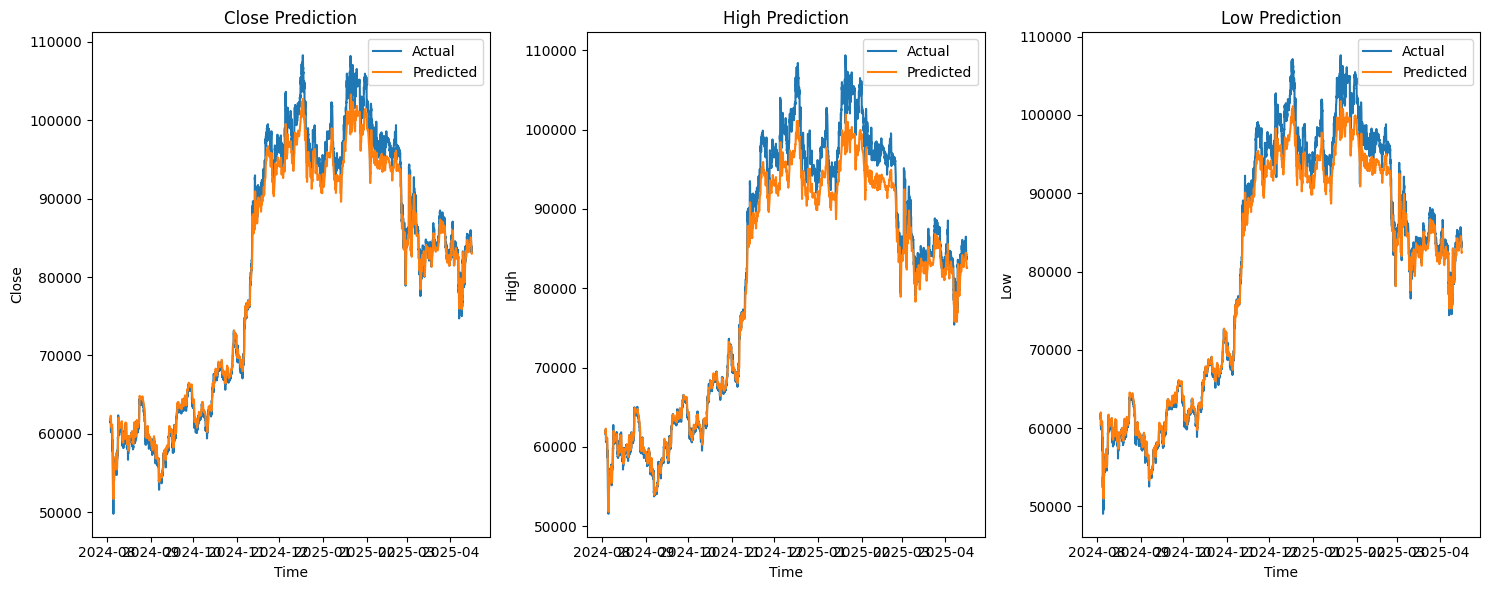

📁 Results saved to prediction_results.csv


In [ ]:
df_train = load_data(TRAIN_FILE, FEATURE_COLUMNS)
scaled_train, scaler = normalize_data(df_train)

target_indices = [FEATURE_COLUMNS.index(col) for col in TARGET_COLUMNS]
X_train, y_train = create_sequences(scaled_train, target_indices, SEQ_LENGTH)

print(f"✅ Training set shape: X={X_train.shape}, y={y_train.shape}")

# === Build and train model ===
model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), output_dim=len(TARGET_COLUMNS))
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

# === Load and normalize test data ===
df_test = load_data(TEST_FILE, FEATURE_COLUMNS, include_time=True)
time_labels = df_test[DATETIME_COLUMN].iloc[SEQ_LENGTH:]  # Align time with prediction steps

df_test_no_time = df_test[FEATURE_COLUMNS]  # drop datetime for normalization
scaled_test, _ = normalize_data(df_test_no_time, scaler)
X_test, y_test = create_sequences(scaled_test, target_indices, SEQ_LENGTH)

print(f"✅ Testing set shape: X={X_test.shape}, y={y_test.shape}")
print(f"🕒 Predicting for {len(X_test)} hours ≈ {len(X_test) / 24:.1f} days")

# === Predict and inverse transform ===
predictions = model.predict(X_test)
print(predictions)
print(predictions.shape)

dummy = np.zeros((predictions.shape[0], len(FEATURE_COLUMNS)))
dummy[:, target_indices] = predictions
predicted_prices = scaler.inverse_transform(dummy)[:, target_indices]

dummy[:, target_indices] = y_test
actual_prices = scaler.inverse_transform(dummy)[:, target_indices]

# === Plot results ===
plot_predictions(actual_prices, predicted_prices, TARGET_COLUMNS, time_labels)

# === Save results to CSV ===
result_df = pd.DataFrame({
    DATETIME_COLUMN: time_labels,
    **{f'actual_{col}': actual_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
    **{f'predicted_{col}': predicted_prices[:, i] for i, col in enumerate(TARGET_COLUMNS)},
})
result_df.to_csv("prediction_results.csv", index=False)
print("📁 Results saved to prediction_results.csv")

In [ ]:
print(predictions.shape)
print(predictions)

(6148, 3)
[[0.6605995  0.65486157 0.65269554]
 [0.66085535 0.65546143 0.65385926]
 [0.66202927 0.6567404  0.6561211 ]
 ...
 [1.269587   1.250378   1.264246  ]
 [1.2694987  1.2503016  1.2647501 ]
 [1.2693253  1.2500737  1.2650821 ]]


In [ ]:
print(df_test.shape)

(6208, 6)


In [ ]:
import Backtesting
from Backtesting.models.lstm import LSTMModel

✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0490
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 5.2989e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.7994e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.7402e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.2587e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.4341e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.5528e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.9939e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.2131e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.2844e-04
✅ Testing set shape: X=(6148, 60, 5), y=(6148, 3)
🕒 Predicting for 6148 hours ≈ 256.2 days
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


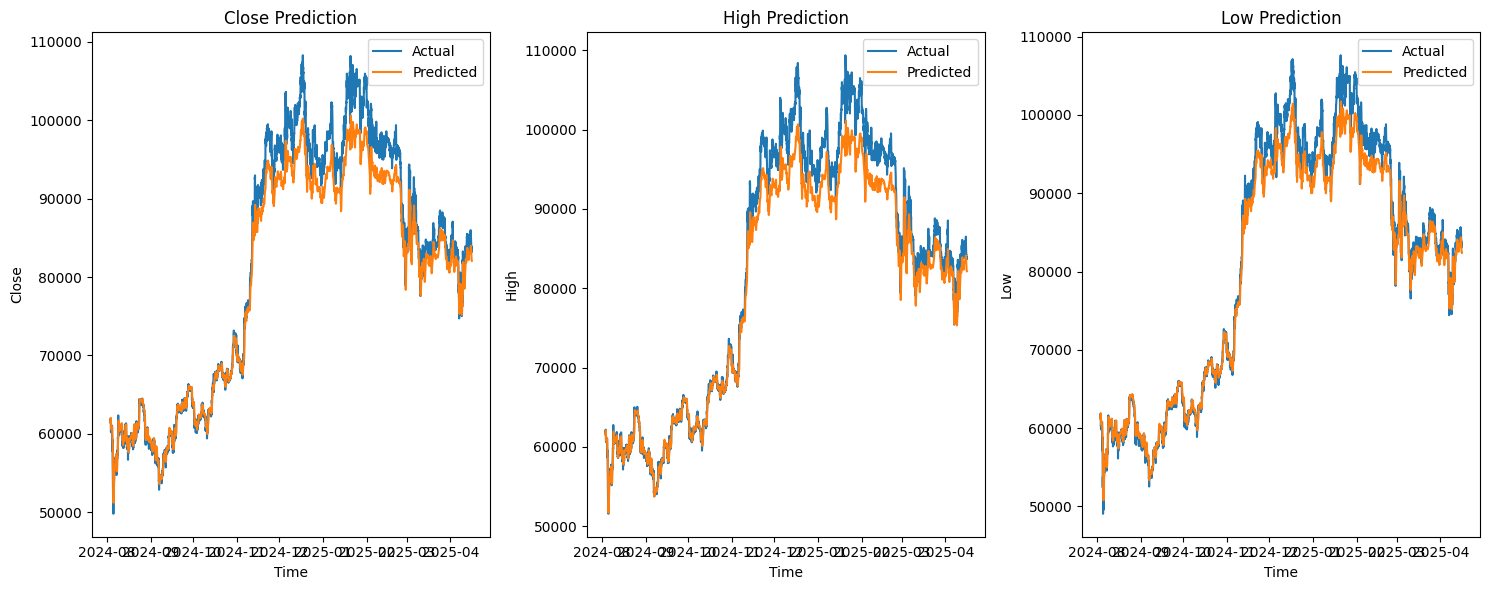

📁 Results saved to prediction_results.csv


In [ ]:
lstm = LSTMModel('datasets/BTC-USD_1h_Training_data.csv')
lstm.train()
lstm.predict('datasets/BTC-USD_1h_Testing_data.csv')

In [ ]:
print(lstm.result_df)

               timestamp  actual_close  actual_high  actual_low  \
60   2024-08-03 04:00:00      61495.32     61922.72    61328.73   
61   2024-08-03 05:00:00      61636.79     61652.38    61429.98   
62   2024-08-03 06:00:00      61760.69     61779.42    61596.56   
63   2024-08-03 07:00:00      61613.41     61846.15    61554.27   
64   2024-08-03 08:00:00      61575.44     61692.98    61421.03   
...                  ...           ...          ...         ...   
6203 2025-04-16 03:00:00      83681.40     83946.70    83650.00   
6204 2025-04-16 04:00:00      83581.15     83785.50    83366.25   
6205 2025-04-16 05:00:00      83352.63     83814.06    83209.52   
6206 2025-04-16 06:00:00      83638.98     83719.79    83260.92   
6207 2025-04-16 07:00:00      83349.86     83759.59    83298.77   

      predicted_close  predicted_high  predicted_low  
60       61448.445777    61559.011313   61188.458170  
61       61445.438543    61520.370647   61208.824482  
62       61474.763764    61523

In [ ]:
from Backtesting.strategies.deepPredictorStrategy import DeepPredictorStrategy

lstmStra = DeepPredictorStrategy('datasets/BTC-USD_1h_Training_data.csv', 60, 10, 32)



✅ Training set shape: X=(4940, 60, 5), y=(4940, 3)
Epoch 1/10


/Users/winnee/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0407
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.8306e-04
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.6086e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 5.9593e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 4.3523e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.2060e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.8150e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.7768e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 3.2080e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 3.4362e-04


✅ Testing set shape: X=(4940, 60, 5), y=(4940, 3)
🕒 Predicting for 4940 hours ≈ 205.8 days
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


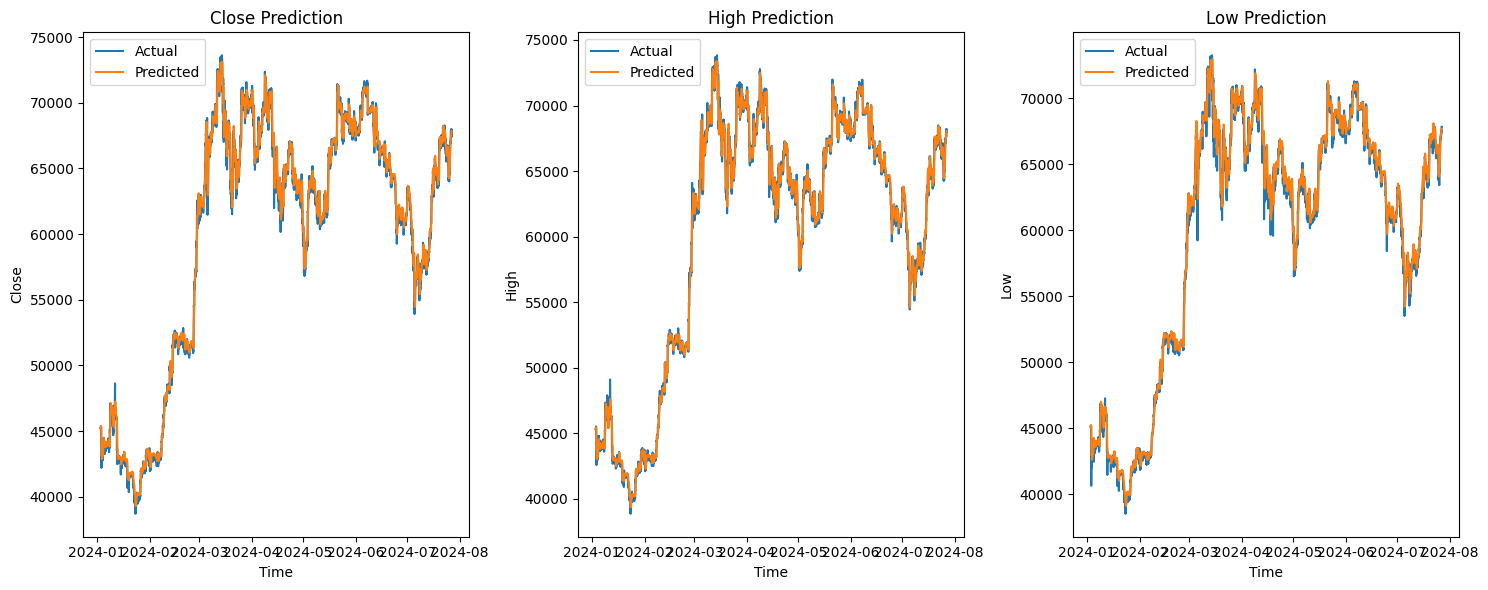

📁 Results saved to prediction_results.csv
Results from LSTM model:
               timestamp  actual_close  actual_high  actual_low  \
60   2024-01-03 04:00:00      45203.08     45297.02    45140.01   
61   2024-01-03 05:00:00      45184.54     45312.12    45122.08   
62   2024-01-03 06:00:00      45344.02     45383.66    45172.77   
63   2024-01-03 07:00:00      45027.43     45405.55    44957.01   
64   2024-01-03 08:00:00      45219.26     45223.90    45021.26   
...                  ...           ...          ...         ...   
4995 2024-07-26 19:00:00      68008.63     68175.00    67536.30   
4996 2024-07-26 20:00:00      67446.94     68031.76    67423.73   
4997 2024-07-26 21:00:00      67948.94     68216.66    67435.79   
4998 2024-07-26 22:00:00      67938.68     68098.74    67850.01   
4999 2024-07-26 23:00:00      67924.08     67986.97    67844.83   

      predicted_close  predicted_high  predicted_low  
60       45269.079353    45359.994426   45079.777654  
61       45303.202

In [ ]:


lstmStra.generate_signals()

In [ ]:
print(lstmStra.signals)

['buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'sell', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'buy', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'buy', 'buy', 'buy', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'sell', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'sell', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'buy', 'sell', 'sell', 'buy', 'buy', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 's

In [ ]:
print(lstmStra.result_df)

               timestamp  actual_close  actual_high  actual_low  \
61   2024-01-03 05:00:00      45184.54     45312.12    45122.08   
62   2024-01-03 06:00:00      45344.02     45383.66    45172.77   
63   2024-01-03 07:00:00      45027.43     45405.55    44957.01   
64   2024-01-03 08:00:00      45219.26     45223.90    45021.26   
65   2024-01-03 09:00:00      45358.71     45519.32    45200.22   
...                  ...           ...          ...         ...   
4995 2024-07-26 19:00:00      68008.63     68175.00    67536.30   
4996 2024-07-26 20:00:00      67446.94     68031.76    67423.73   
4997 2024-07-26 21:00:00      67948.94     68216.66    67435.79   
4998 2024-07-26 22:00:00      67938.68     68098.74    67850.01   
4999 2024-07-26 23:00:00      67924.08     67986.97    67844.83   

      predicted_close  predicted_high  predicted_low signal  
61       45303.202623    45389.440469   45121.446237    buy  
62       45326.948332    45404.633987   45154.572572    buy  
63       

In [1]:
from Backtesting.strategies.marketRegimeStrategy_simplified import MarketRegimeStrategy
import pandas as pd
marketRegime = MarketRegimeStrategy('datasets/BTC-USD_1h_Training_data.csv', 0.7, 0.3)


         1  -29561.66802541             +nan
         2  -18702.60335718  +10859.06466823
         3  -17760.10664464    +942.49671254
         4  -17087.68121931    +672.42542533
         5  -16695.67355956    +392.00765975
         6  -16448.99171181    +246.68184775
         7  -16274.13474999    +174.85696182
         8  -16134.42520081    +139.70954918
         9  -16021.76979713    +112.65540369
        10  -15936.37351562     +85.39628150
        11  -15872.71434917     +63.65916645
        12  -15818.30517014     +54.40917903
        13  -15760.36367042     +57.94149972
        14  -15687.23054585     +73.13312458
        15  -15587.68760442     +99.54294142
        16  -15459.58276676    +128.10483766
        17  -15331.56114574    +128.02162102
        18  -15239.46482627     +92.09631947
        19  -15185.48609794     +53.97872832
        20  -15154.95836431     +30.52773363
        21  -15136.16644652     +18.79191779
        22  -15123.07323319     +13.09321333
        23

Converged: True
Final log likelihood: -15002.427465787981
State Labels: {0: 'bullish', 1: 'bearish', 2: 'neutral'}
               timestamp      open     close  log_return  state market_state
1    2023-12-31 17:00:00  42576.72  42590.03    0.000312      0      bullish
2    2023-12-31 18:00:00  42592.75  42637.17    0.001106      0      bullish
3    2023-12-31 19:00:00  42637.17  42591.94   -0.001061      0      bullish
4    2023-12-31 20:00:00  42589.87  42533.28   -0.001378      0      bullish
5    2023-12-31 21:00:00  42531.41  42492.24   -0.000965      0      bullish
...                  ...       ...       ...         ...    ...          ...
4995 2024-07-26 19:00:00  67573.11  68008.63    0.006425      0      bullish
4996 2024-07-26 20:00:00  68008.08  67446.94   -0.008293      0      bullish
4997 2024-07-26 21:00:00  67446.93  67948.94    0.007415      0      bullish
4998 2024-07-26 22:00:00  67948.95  67938.68   -0.000151      2      neutral
4999 2024-07-26 23:00:00  67942.55  67

       121  -15002.61774296      +0.02265227
       122  -15002.59655389      +0.02118906
       123  -15002.57673387      +0.01982003
       124  -15002.55819472      +0.01853915
       125  -15002.54085393      +0.01734079
       126  -15002.52463426      +0.01621967
       127  -15002.50946342      +0.01517084
       128  -15002.49527376      +0.01418966
       129  -15002.48200197      +0.01327179
       130  -15002.46958881      +0.01241316
       131  -15002.45797883      +0.01160997
       132  -15002.44712017      +0.01085866
       133  -15002.43696430      +0.01015588
       134  -15002.42746579      +0.00949851


In [2]:
hmm_results = marketRegime.generate_signals(pd.read_csv('datasets/BTC-USD_1h_Training_data.csv'))
print(hmm_results)

               timestamp      open      high       low     close       volume  \
1    2023-12-31 17:00:00  42576.72  42625.00  42450.35  42590.03   386.220176   
2    2023-12-31 18:00:00  42592.75  42700.00  42510.71  42637.17   418.603368   
3    2023-12-31 19:00:00  42637.17  42669.99  42512.37  42591.94   515.571487   
4    2023-12-31 20:00:00  42589.87  42651.77  42477.91  42533.28   557.491886   
5    2023-12-31 21:00:00  42531.41  42641.38  42485.70  42492.24   491.875463   
...                  ...       ...       ...       ...       ...          ...   
4995 2024-07-26 19:00:00  67573.11  68175.00  67536.30  68008.63  1110.159318   
4996 2024-07-26 20:00:00  68008.08  68031.76  67423.73  67446.94   661.413459   
4997 2024-07-26 21:00:00  67446.93  68216.66  67435.79  67948.94   354.088604   
4998 2024-07-26 22:00:00  67948.95  68098.74  67850.01  67938.68   143.199670   
4999 2024-07-26 23:00:00  67942.55  67986.97  67844.83  67924.08   141.017540   

      log_return  prob_bull

In [1]:
from Backtesting.strategies.metaFusionStrategy import MetaFusionStrategy
import pandas as pd

mfs = MetaFusionStrategy('datasets/BTC-USD_1h_Training_data.csv')




         1  -28023.62969157             +nan
         2  -17864.79322285  +10158.83646872
         3  -16746.07835350   +1118.71486934
         4  -16225.24077897    +520.83757454
         5  -15923.40850588    +301.83227308
         6  -15704.34853712    +219.05996876
         7  -15553.60899714    +150.73953998
         8  -15452.84353548    +100.76546166
         9  -15376.17413986     +76.66939562
        10  -15317.37101389     +58.80312597
        11  -15273.60429744     +43.76671645
        12  -15241.04047549     +32.56382196
        13  -15216.05325703     +24.98721845
        14  -15196.06725890     +19.98599814
        15  -15179.54694316     +16.52031573
        16  -15165.55526252     +13.99168065
        17  -15153.45490404     +12.10035848
        18  -15142.77482211     +10.68008193
        19  -15133.15911538      +9.61570672
        20  -15124.35625052      +8.80286486
        21  -15116.20903264      +8.14721788
        22  -15108.63279543      +7.57623721
        23

Converged: True
Final log likelihood: -15002.425927095434
State Labels: {2: 'bullish', 1: 'bearish', 0: 'neutral'}
               timestamp      open     close  log_return  state market_state
1    2023-12-31 17:00:00  42576.72  42590.03    0.000312      2      bullish
2    2023-12-31 18:00:00  42592.75  42637.17    0.001106      2      bullish
3    2023-12-31 19:00:00  42637.17  42591.94   -0.001061      2      bullish
4    2023-12-31 20:00:00  42589.87  42533.28   -0.001378      2      bullish
5    2023-12-31 21:00:00  42531.41  42492.24   -0.000965      2      bullish
...                  ...       ...       ...         ...    ...          ...
4995 2024-07-26 19:00:00  67573.11  68008.63    0.006425      2      bullish
4996 2024-07-26 20:00:00  68008.08  67446.94   -0.008293      2      bullish
4997 2024-07-26 21:00:00  67446.93  67948.94    0.007415      2      bullish
4998 2024-07-26 22:00:00  67948.95  67938.68   -0.000151      0      neutral
4999 2024-07-26 23:00:00  67942.55  67

Predict data fram in marketregimestrategy:                 timestamp      open      high       low     close       volume
0     2023-12-31 16:00:00  42435.51  42681.02  42405.86  42576.73   483.456075
1     2023-12-31 17:00:00  42576.72  42625.00  42450.35  42590.03   386.220176
2     2023-12-31 18:00:00  42592.75  42700.00  42510.71  42637.17   418.603368
3     2023-12-31 19:00:00  42637.17  42669.99  42512.37  42591.94   515.571487
4     2023-12-31 20:00:00  42589.87  42651.77  42477.91  42533.28   557.491886
...                   ...       ...       ...       ...       ...          ...
4995  2024-07-26 19:00:00  67573.11  68175.00  67536.30  68008.63  1110.159318
4996  2024-07-26 20:00:00  68008.08  68031.76  67423.73  67446.94   661.413459
4997  2024-07-26 21:00:00  67446.93  68216.66  67435.79  67948.94   354.088604
4998  2024-07-26 22:00:00  67948.95  68098.74  67850.01  67938.68   143.199670
4999  2024-07-26 23:00:00  67942.55  67986.97  67844.83  67924.08   141.017540

[5000 ro

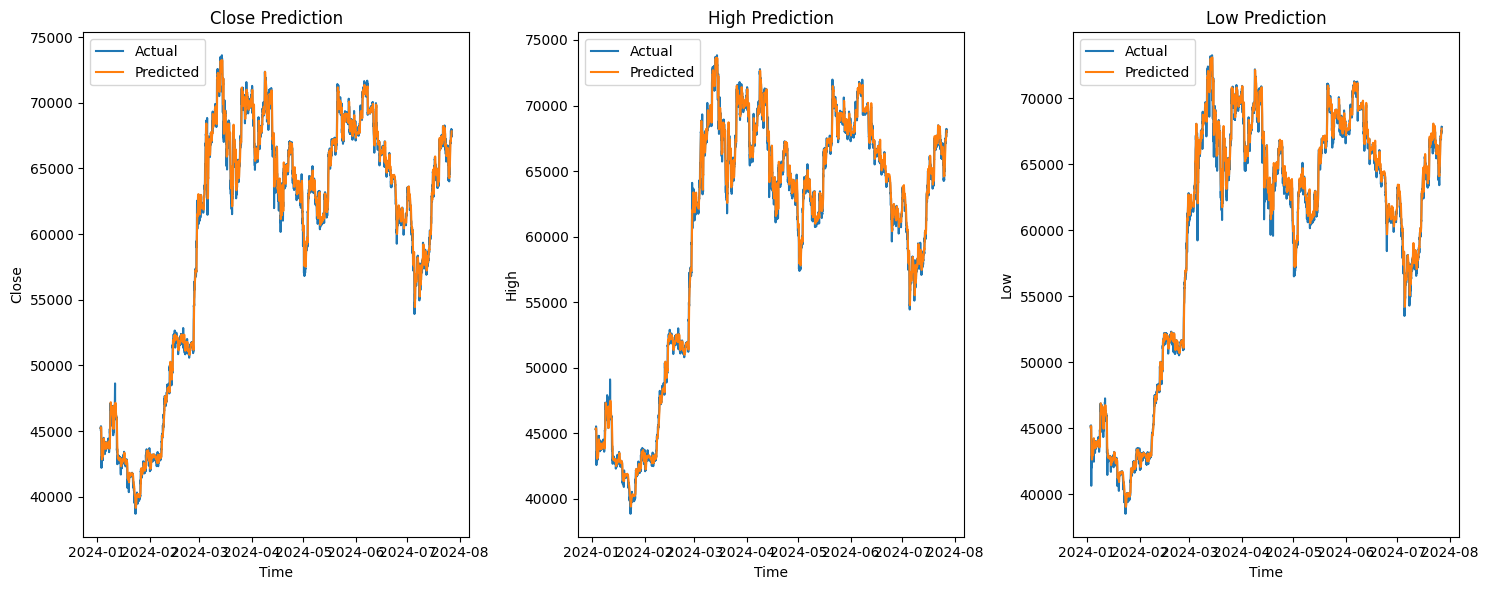

📁 Results saved to prediction_results.csv
Results from LSTM model:
               timestamp  actual_close  actual_high  actual_low  \
60   2024-01-03 04:00:00      45203.08     45297.02    45140.01   
61   2024-01-03 05:00:00      45184.54     45312.12    45122.08   
62   2024-01-03 06:00:00      45344.02     45383.66    45172.77   
63   2024-01-03 07:00:00      45027.43     45405.55    44957.01   
64   2024-01-03 08:00:00      45219.26     45223.90    45021.26   
...                  ...           ...          ...         ...   
4995 2024-07-26 19:00:00      68008.63     68175.00    67536.30   
4996 2024-07-26 20:00:00      67446.94     68031.76    67423.73   
4997 2024-07-26 21:00:00      67948.94     68216.66    67435.79   
4998 2024-07-26 22:00:00      67938.68     68098.74    67850.01   
4999 2024-07-26 23:00:00      67924.08     67986.97    67844.83   

      predicted_close  predicted_high  predicted_low  
60       45238.029914    45333.962545   45063.763787  
61       45272.078

In [2]:
mfs.preprocess_data('datasets/BTC-USD_1h_Training_data.csv')

In [3]:
print(mfs.deepPredictorData)
print(mfs.marketRegimeData)

result = mfs.merge_model_outputs()

               timestamp  actual_close  actual_high  actual_low  \
61   2024-01-03 05:00:00      45184.54     45312.12    45122.08   
62   2024-01-03 06:00:00      45344.02     45383.66    45172.77   
63   2024-01-03 07:00:00      45027.43     45405.55    44957.01   
64   2024-01-03 08:00:00      45219.26     45223.90    45021.26   
65   2024-01-03 09:00:00      45358.71     45519.32    45200.22   
...                  ...           ...          ...         ...   
4995 2024-07-26 19:00:00      68008.63     68175.00    67536.30   
4996 2024-07-26 20:00:00      67446.94     68031.76    67423.73   
4997 2024-07-26 21:00:00      67948.94     68216.66    67435.79   
4998 2024-07-26 22:00:00      67938.68     68098.74    67850.01   
4999 2024-07-26 23:00:00      67924.08     67986.97    67844.83   

      predicted_close  predicted_high  predicted_low deepPredictor  
61       45272.078264    45356.140786   45106.415464           buy  
62       45289.735622    45368.401325   45131.021822     

In [4]:
print(result)

               timestamp  actual_close  actual_high  actual_low  \
0    2024-01-03 05:00:00      45184.54     45312.12    45122.08   
1    2024-01-03 06:00:00      45344.02     45383.66    45172.77   
2    2024-01-03 07:00:00      45027.43     45405.55    44957.01   
3    2024-01-03 08:00:00      45219.26     45223.90    45021.26   
4    2024-01-03 09:00:00      45358.71     45519.32    45200.22   
...                  ...           ...          ...         ...   
4934 2024-07-26 19:00:00      68008.63     68175.00    67536.30   
4935 2024-07-26 20:00:00      67446.94     68031.76    67423.73   
4936 2024-07-26 21:00:00      67948.94     68216.66    67435.79   
4937 2024-07-26 22:00:00      67938.68     68098.74    67850.01   
4938 2024-07-26 23:00:00      67924.08     67986.97    67844.83   

      predicted_close  predicted_high  predicted_low deepPredictor      open  \
0        45272.078264    45356.140786   45106.415464           buy  45199.81   
1        45289.735622    45368.4013